# <center>Imports</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable as stb
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from mypca import *

#Plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

%matplotlib inline


# <center>Chargement des données</center>

In [2]:
df = pd.read_csv(r'data/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Toutes les features sont en int64

In [4]:
df.stb.missing().sort_values('missing',ascending=False)

,missing,total,percent
label,0,42000,0.0
pixel23,0,42000,0.0
pixel10,0,42000,0.0
pixel1,0,42000,0.0
pixel2,0,42000,0.0
...,...,...,...
pixel778,0,42000,0.0
pixel779,0,42000,0.0
pixel780,0,42000,0.0
pixel781,0,42000,0.0


Pas de valeurs manquantes

In [5]:
X = df.drop('label',axis=1)
y = df['label']

In [6]:
print('Valeur minimale pour les pixels :',X.min().unique().min())
print('Valeur maximale pour les pixels :',X.max().unique().max())

Valeur minimale pour les pixels : 0
Valeur maximale pour les pixels : 255


Le jeu d'entrainement contient **42000** observations avec **785** features.  
La feature label contient le numéro représenté par les pixels des 784 features suivantes.  
Les **pixels** ont des valeurs entières comprises entre **0 et 255**

# <center> Visualisation de quelques observations</center>

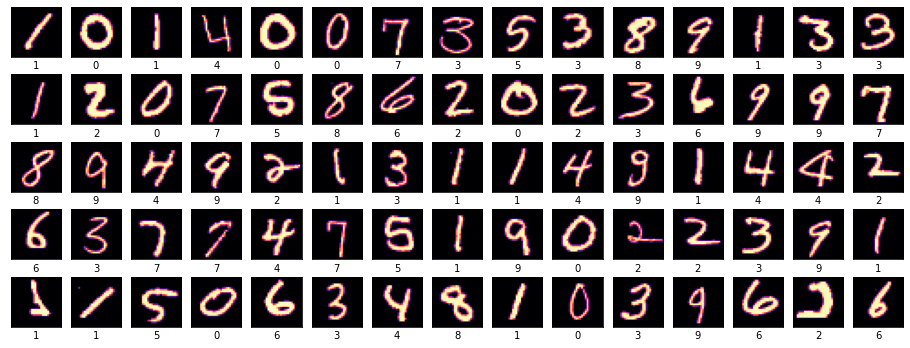

In [7]:
fig, ax = plt.subplots(5, 15, figsize=(16, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(X.loc[i].values.reshape(28,28), cmap='magma')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

# <center> Représentation des digits </center>

In [8]:
df.stb.freq(['label'])

,label,count,percent,cumulative_count,cumulative_percent
0,1,4684,11.152381,4684,11.152381
1,7,4401,10.478571,9085,21.630952
2,3,4351,10.359524,13436,31.990476
3,9,4188,9.971429,17624,41.961905
4,2,4177,9.945238,21801,51.907143
5,6,4137,9.850000,25938,61.757143
6,0,4132,9.838095,30070,71.595238
7,4,4072,9.695238,34142,81.290476
8,8,4063,9.673810,38205,90.964286
9,5,3795,9.035714,42000,100.000000


Les chiffres sont tous bien représentés, proche de 10% pour chacun

# <center> Création du modèle avec l'ensemble des données </center>

## <center> Séparation jeu d'entrainement/test </center>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [10]:
df_train = X_train.copy()
df_train['label'] = y_train
df_train.stb.freq(['label'])

,label,count,percent,cumulative_count,cumulative_percent
0,1,3747,11.151786,3747,11.151786
1,7,3521,10.479167,7268,21.630952
2,3,3481,10.360119,10749,31.991071
3,9,3350,9.970238,14099,41.961310
4,2,3342,9.946429,17441,51.907738
5,6,3309,9.848214,20750,61.755952
6,0,3306,9.839286,24056,71.595238
7,4,3258,9.696429,27314,81.291667
8,8,3250,9.672619,30564,90.964286
9,5,3036,9.035714,33600,100.000000


In [11]:
df_test = X_test.copy()
df_test['label'] = y_test
df_test.stb.freq(['label'])

,label,count,percent,cumulative_count,cumulative_percent
0,1,937,11.154762,937,11.154762
1,7,880,10.476190,1817,21.630952
2,3,870,10.357143,2687,31.988095
3,9,838,9.976190,3525,41.964286
4,2,835,9.940476,4360,51.904762
5,6,828,9.857143,5188,61.761905
6,0,826,9.833333,6014,71.595238
7,4,814,9.690476,6828,81.285714
8,8,813,9.678571,7641,90.964286
9,5,759,9.035714,8400,100.000000


grâce au stratify, les proportions sont respectées dans les deux jeux

## <center> ACP pour réduction des dimensions </center>

In [12]:
pca = PCA(n_components=100) 
pca.fit(X_train)

PCA(n_components=100)

In [13]:
my_scree(pca) 

Unsupported


avec **86 composantes** on arrive à **90% de la variance expliquée**

In [14]:
pca = PCA(n_components=86) 
pca.fit(X_train)

PCA(n_components=86)

In [15]:
pcs = pca.components_
X_train_projected = pca.transform(X_train)
pca.get_params

<bound method BaseEstimator.get_params of PCA(n_components=86)>

In [16]:
np.array(X_train.index)

array([ 6783, 25245, 21576, ..., 22469, 30311, 13153])

In [17]:
my_pca(pcs, 2, pca, np.array(X_train.columns),X_train_projected,np.array(y_train),names=np.array(X_train.index),draw_circle=False)

Unsupported

On peut voir que rien que les deux premières composantes permettent déjà de bien départager certains chiffres : le 0 et le 1 par exemple sont opposés sur la projection !  

Elles ne sont évidemment pas suffisantes :  
on retrouve le 4, 7 et 9 très proches en haut et de la même façon les chiffres restants sont mélangés au milieu/en bas

## <center> Modèles avec ACP </center>

In [18]:
def evaluate_model(model,X_train, y_train, X_test, y_test, with_grid=False, param_grid=None):
    print("_________________________________________________")
    print("DEBUT MODEL")
    print("_________________________________________________")
    if with_grid:
        if param_grid is None:
            param_grid = {'svc__C': [1, 5, 10, 50],
                          'svc__gamma': ["scale"]}
        
        grid = GridSearchCV(model, param_grid)
        grid.fit(X_train, y_train)
        print("**Résultat grid search**")
        print(grid.best_params_)
        print("")
        model = grid.best_estimator_
    else:
        model.fit(X_train, y_train)
        
    y_pred = model.predict(X_test)
    
    print("**Matrice de confusion**")
    print("")
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title('Matrice de confusion - Précision moyenne = ' + str(round(accuracy_score(y_test,y_pred),3)))
    plt.show()
    
    print(classification_report(y_test, y_pred))
    
    print("_________________________________________________")
    print("FIN MODEL")
    print("_________________________________________________")
    
    return model

#### <center> Linear </center>

In [19]:
svc = SVC(kernel='linear', class_weight='balanced', probability=True)
model_linear_pca = make_pipeline(pca, svc)
#model_linear_pca = evaluate_model(model_linear_pca,X_train, y_train, X_test, y_test)

<img align="left" style="padding-right:10px;" src="img/linear_pca.jpg">

#### <center> Poly </center>

In [20]:
svc = SVC(kernel='poly', class_weight='balanced', probability=True)
model_poly_pca = make_pipeline(pca, svc)
#model_poly_pca = evaluate_model(model_poly_pca,X_train, y_train, X_test, y_test)

<img align="left" style="padding-right:10px;" src="img/poly_pca.jpg">

#### <center> Rbf </center>

In [21]:
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model_rbf_pca = make_pipeline(pca, svc)
#model_rbf_pca = evaluate_model(model_rbf_pca,X_train, y_train, X_test, y_test)

<img align="left" style="padding-right:10px;" src="img/rbf_pca.jpg">

# <center> Création des modèles avec une part des données </center>

## <center> Test avec double découpe avec train_test_split (réduction du volume de données) </center>

In [22]:
X_red , _ ,y_red , _ = train_test_split(X, y, test_size = 0.8, random_state = 42, stratify=y)

In [23]:
X_train_r, X_test_r,y_train_r, y_test_r = train_test_split(X_red, y_red, test_size = 0.2, random_state = 42, stratify=y_red)

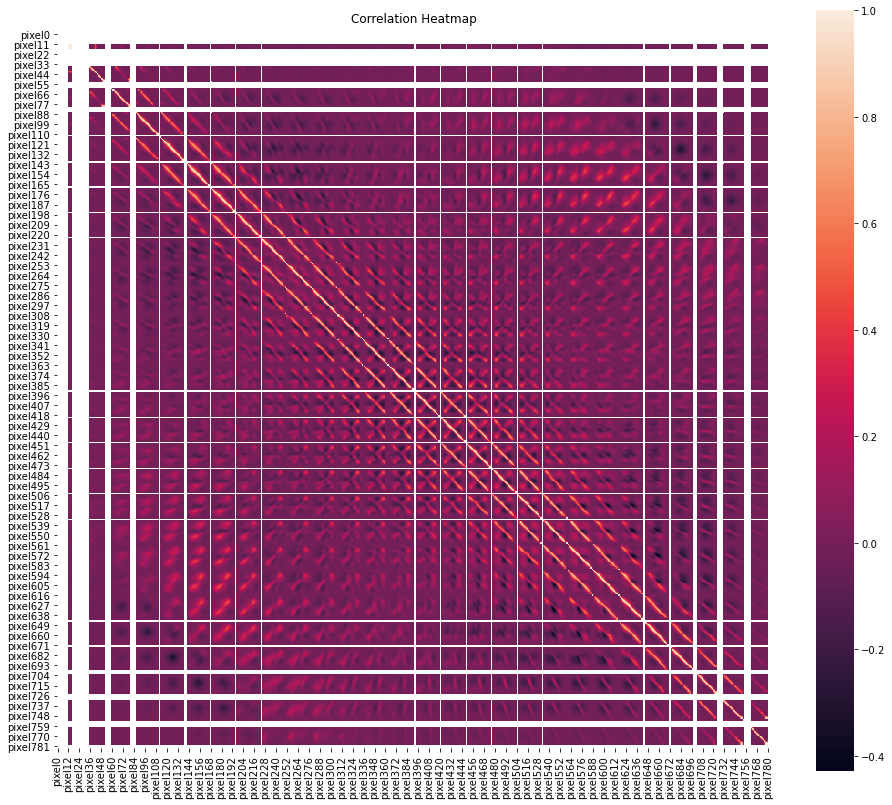

In [29]:
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(X_train_r.corr(),square=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## <center> Créations des modèles </center>

### <center> SVC avec kernel 'linear' </center>

In [24]:
svc_linear = SVC(kernel="linear")
svc_linear.fit(X_train_r, y_train_r)
y_pred_r_linear = svc_linear.predict(X_test_r)
round(accuracy_score(y_test_r,y_pred_r_linear),3) #équivalant de svc_score = svc_linear.score(X_test_r, y_test_r)


0.916

### <center> SVC avec kernel 'rbf' </center>

In [65]:
svc_rbf = SVC(kernel='rbf',probability=True)
svc_rbf.fit(X_train_r,y_train_r)
y_pred_r_rbf = svc_rbf.predict(X_test_r)
round(accuracy_score(y_test_r,y_pred_r_rbf),3)

0.962

### <center> SVC avec kernel 'poly' </center>

In [26]:
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train_r, y_train_r)
y_pred_r_poly = svc_poly.predict(X_test_r)
round(accuracy_score(y_test_r,y_pred_r_poly),3)

0.942

## <center> Matrices de confusion </center>

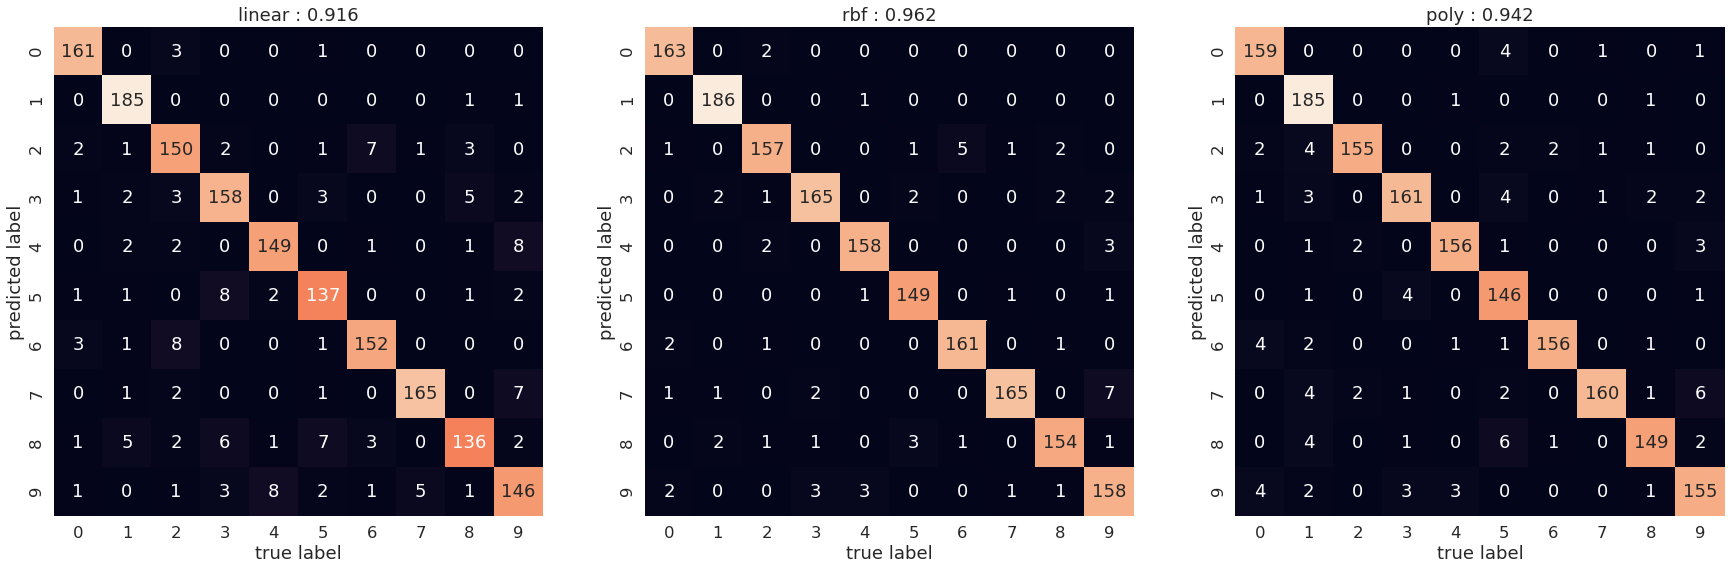

In [35]:
#sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

#créer 3 subplots vide
fig, axes = plt.subplots(1,3,figsize=(30,9))

#charge les subplots
name_list = ['linear','rbf','poly']
for i,item in enumerate([y_pred_r_linear, y_pred_r_rbf,y_pred_r_poly]) :
    sns.heatmap(confusion_matrix(y_test_r,item),square=True,fmt='d',cbar=False,ax=axes[i],annot=True)
    axes[i].set_title(name_list[i] + ' : ' + str(round(accuracy_score(y_test_r,item),3)))
    axes[i].set_xlabel('true label')
    axes[i].set_ylabel('predicted label')
    
#montrer les graphs
plt.show()

## <center> Rapport de classification </center>

In [28]:
dict_y_pred = {'linear':y_pred_r_linear,'poly':y_pred_r_poly,'rbf':y_pred_r_rbf}
for key in dict_y_pred :
    report = classification_report(y_test_r,dict_y_pred[key],output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    print(key)
    print(df_classification_report)
    print("")

linear
              precision    recall  f1-score      support
0              0.947059  0.975758  0.961194   165.000000
1              0.934343  0.989305  0.961039   187.000000
2              0.877193  0.898204  0.887574   167.000000
3              0.892655  0.908046  0.900285   174.000000
4              0.931250  0.914110  0.922601   163.000000
5              0.895425  0.901316  0.898361   152.000000
6              0.926829  0.921212  0.924012   165.000000
7              0.964912  0.937500  0.951009   176.000000
8              0.918919  0.834356  0.874598   163.000000
9              0.869048  0.869048  0.869048   168.000000
accuracy       0.916071  0.916071  0.916071     0.916071
macro avg      0.915763  0.914885  0.914972  1680.000000
weighted avg   0.916211  0.916071  0.915785  1680.000000

poly
              precision    recall  f1-score      support
0              0.935294  0.963636  0.949254   165.000000
1              0.898058  0.989305  0.941476   187.000000
2              0.9

## <center> Création des modèles avec composantes réduites par ACP </center>

In [29]:
pca_r = PCA(n_components=100) 
pca_r.fit(X_train_r)
my_scree(pca_r) 

Unsupported

In [30]:
pca_r = PCA(n_components=86)
pca_r.fit(X_train_r)
X_train_r_projected = pca_r.transform(X_train_r)

In [32]:
"""svc_linear_pca = SVC(kernel="linear",class_weight="balanced")
model_linear_pca = make_pipeline(pca_r, svc_linear_pca)
evaluate_model(model_linear_pca,X_train_r, y_train_r, X_test_r, y_test_r)"""

'svc_linear_pca = SVC(kernel="linear",class_weight="balanced")\nmodel_linear_pca = make_pipeline(pca_r, svc_linear_pca)\nevaluate_model(model_linear_pca,X_train_r, y_train_r, X_test_r, y_test_r)'

_________________________________________________
DEBUT MODEL
_________________________________________________
**Matrice de confusion**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       165
           1       0.98      0.99      0.98       187
           2       0.97      0.98      0.97       167
           3       0.96      0.95      0.96       174
           4       0.96      0.98      0.97       163
           5       0.94      0.96      0.95       152
           6       0.99      0.98      0.98       165
           7       0.99      0.94      0.96       176
           8       0.97      0.96      0.96       163
           9       0.93      0.97      0.95       168

    accuracy                           0.97      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.97      0.97      0.97      1680

_________________________________________________
FIN MODEL
___________________________________________

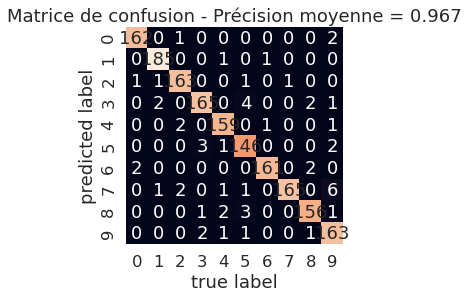

In [36]:
svc_poly_pca = SVC(kernel="poly",class_weight="balanced")
model_poly_pca = make_pipeline(pca_r, svc_poly_pca)
evaluate_model(model_poly_pca,X_train_r, y_train_r, X_test_r, y_test_r)

_________________________________________________
DEBUT MODEL
_________________________________________________
**Matrice de confusion**

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       165
           1       0.98      0.99      0.99       187
           2       0.98      0.96      0.97       167
           3       0.97      0.95      0.96       174
           4       0.98      0.98      0.98       163
           5       0.97      0.97      0.97       152
           6       0.97      0.98      0.98       165
           7       0.99      0.94      0.97       176
           8       0.96      0.95      0.96       163
           9       0.93      0.96      0.95       168

    accuracy                           0.97      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.97      0.97      0.97      1680

_________________________________________________
FIN MODEL
___________________________________________

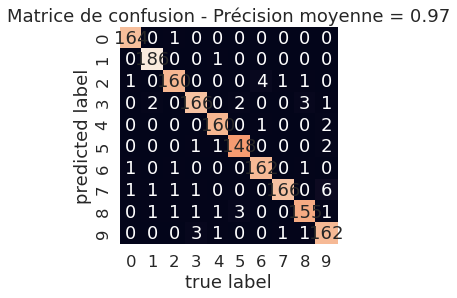

In [34]:
svc_rbf_pca = SVC(kernel="rbf",class_weight="balanced")
model_rbf_pca = make_pipeline(pca_r, svc_rbf_pca)
evaluate_model(model_rbf_pca,X_train_r, y_train_r, X_test_r, y_test_r)

## Optimisation des hyper paramètres avec le modèle rbf acp

In [53]:
param_grid = {'svc__C': [100,101,102],
                          'svc__gamma': ["scale"]}
evaluate_model(model_rbf_pca,X_train_r, y_train_r, X_test_r, y_test_r,with_grid=True,param_grid=param_grid)

_________________________________________________
DEBUT MODEL
_________________________________________________
**Résultat grid search**
{'svc__C': 101, 'svc__gamma': 'scale'}

**Matrice de confusion**

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       165
           1       0.97      0.99      0.98       187
           2       0.97      0.96      0.96       167
           3       0.98      0.97      0.97       174
           4       0.97      0.98      0.98       163
           5       0.97      0.98      0.97       152
           6       0.98      0.98      0.98       165
           7       0.99      0.95      0.97       176
           8       0.97      0.96      0.97       163
           9       0.94      0.96      0.95       168

    accuracy                           0.97      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.97      0.97      0.97      1680

______________________________________

Pipeline(steps=[('pca', PCA(n_components=86)),
                ('svc', SVC(C=101, class_weight='balanced'))])

Ok, meilleur param C = 101

_________________________________________________
DEBUT MODEL
_________________________________________________
**Matrice de confusion**

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       165
           1       0.97      0.99      0.98       187
           2       0.97      0.96      0.96       167
           3       0.97      0.97      0.97       174
           4       0.97      0.98      0.98       163
           5       0.97      0.98      0.97       152
           6       0.98      0.98      0.98       165
           7       0.99      0.95      0.97       176
           8       0.97      0.96      0.97       163
           9       0.94      0.96      0.95       168

    accuracy                           0.97      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.97      0.97      0.97      1680

_________________________________________________
FIN MODEL
___________________________________________

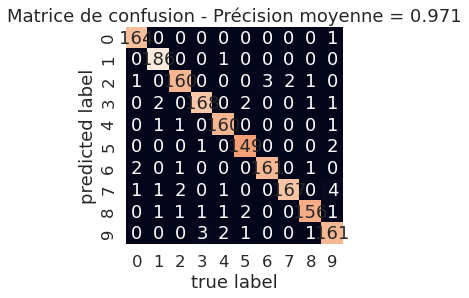

In [60]:
svc_rbf_pca_hp = SVC(kernel="rbf",class_weight="balanced",C=101,probability=True)
model_rbf_pca_hp = make_pipeline(pca_r, svc_rbf_pca_hp)
model_rbf_pca_hp = evaluate_model(model_rbf_pca_hp,X_train_r, y_train_r, X_test_r, y_test_r)

# Compte rendu des différents modèles

In [56]:
liste_models = ['linear alldata pca',
                'poly alldata pca',
                'rbf alldata pca',
                'linear smalldata',
                'rbf smalldata',
                'poly smalldata',
                'linear smalldata pca',
                'rbf smalldata pca',
                'poly smalldata pca',
                'rbf  smalldata pca opti'
]

accuracy_models = [0.932,
                0.973,
                0.977,
                0.916,
                0.962,
                0.942,
                np.NaN,
                0.97,
                0.967,
                0.972    
]

treatment_time = [np.NaN,
            np.NaN,
            np.NaN,
            5.6,
            20.7,
            18.8,
            np.NaN,
            3.9,
            4.2,
            3.8
]

df_model_comparaison = pd.DataFrame(columns=['accuracy','time'],index=liste_models)
df_model_comparaison['accuracy'] = accuracy_models
df_model_comparaison['time'] = treatment_time
df_model_comparaison

,accuracy,time
linear alldata pca,0.932,NaN
poly alldata pca,0.973,NaN
rbf alldata pca,0.977,NaN
linear smalldata,0.916,5.6
rbf smalldata,0.962,20.7
poly smalldata,0.942,18.8
linear smalldata pca,NaN,NaN
rbf smalldata pca,0.970,3.9
poly smalldata pca,0.967,4.2
rbf smalldata pca opti,0.972,3.8


# <center> Visualisation des prédictions avec le modèle sélectionné </center>

In [58]:
tmp_r = X_test_r.reset_index(drop=True)
tmp_y = y_test_r.reset_index(drop=True)
y_pred_best_model = model_rbf_pca_hp.predict(X_test_r)

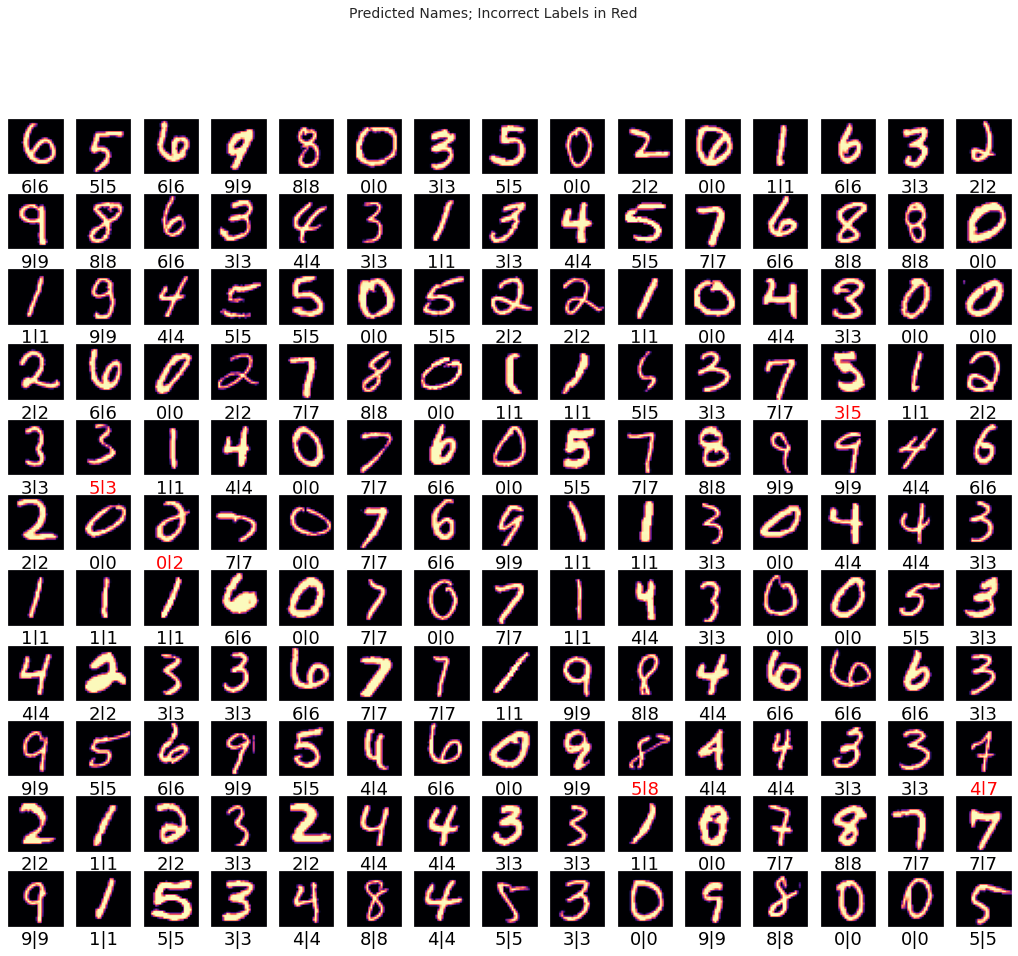

In [59]:
fig, ax = plt.subplots(11, 15, figsize=(18, 15))
for i, axi in enumerate(ax.flat):
    axi.imshow(tmp_r.loc[i].values.reshape(28,28), cmap='magma')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(str(y_pred_best_model[i]) + "|" + str(tmp_y[i]),
                   color='black' if y_pred_best_model[i] == tmp_y[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

# Potentielle amélioration

On pourrait essayer de comparer les modèles avec des précisions globale proches pour trouver la meilleure prédiction possible en prenant les proba de prédiction, mais pas assez de temps pour creuser.  

Exempel avec une des valeurs fausse : 

In [67]:
print(model_rbf_pca_hp.predict_proba(X_test_r)[57])
print(svc_rbf.predict_proba(X_test_r)[57])

[1.01116758e-04 3.56334905e-04 4.18463552e-04 6.51391775e-01
 2.25943241e-05 3.45678154e-01 8.05972720e-05 5.38047189e-05
 1.62239035e-03 2.74769742e-04]
[1.17892592e-04 9.67023396e-04 4.74054388e-04 4.13803375e-01
 3.02196831e-05 5.79151739e-01 1.94415021e-04 6.80304901e-05
 5.03295962e-03 1.60291342e-04]


# Prédictions sur le jeu de test

In [73]:
df_final_pred = pd.read_csv(r'data/test.csv')
df_final_pred.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
df_final_pred.shape

(28000, 784)

In [75]:
y_final_pred = model_rbf_pca_hp.predict(df_final_pred)

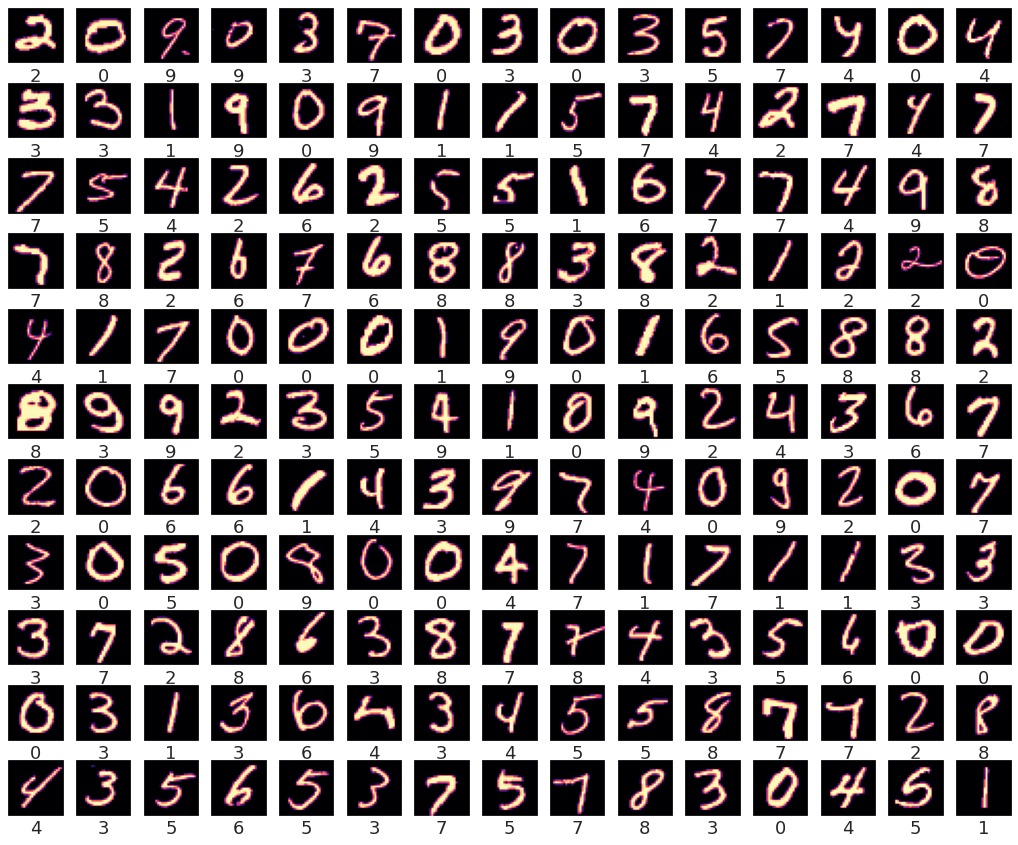

In [77]:
fig, ax = plt.subplots(11, 15, figsize=(18, 15))
for i, axi in enumerate(ax.flat):
    axi.imshow(df_final_pred.loc[i].values.reshape(28,28), cmap='magma')
    axi.set(xticks=[], yticks=[],
            xlabel=y_final_pred[i])